In [2]:
import numpy as np
import  matplotlib.pyplot as plt
import sys
from scipy.stats import kde
from tqdm import tqdm
from sklearn.neighbors import LocalOutlierFactor as LOF
from matplotlib import cm
sys.path.insert(0, '../../Modules')
import erqScaling
import erqMedSpec
import os
def sampler(mean1, cov1, mean2, cov2, NG1, NG2):

    X1 = np.random.multivariate_normal(mean1, cov1, NG1)
    X2= np.random.multivariate_normal(mean2, cov2, NG2)

    X_all = np.concatenate((X1,X2), axis=0)
#     np.savetxt(name, X_all)
    return X_all, X1, X2

In [45]:
#  resampling for LOF score of each bin 
rin=[0, 1.5,2, 2.5, 3.5, 5]
rout=[1.5, 2, 2.5, 3.5,  5, 100]
nBin = len(rin)
nBoot=100
k=50
outG1=[]
outG2=[]
cG2=[]
LOFScoresMedianBins=np.zeros([nBoot,nBin])
opening_angle= np.deg2rad(20)
ERQ_Vector = np.array([1,1])/np.sqrt(2)
#  Obtaining Point A and B for the ERQ wedge

jj=-1
for k in [40,50, 100, 150]:
    for s in tqdm(range(nBoot)):

        # Grawing two Gaussian samples
        (data, G1, G2)=sampler([0,0], [[1,0],[0,1]], [3,3], [[1,0],[0,1]], 30000, 200)
        outG1.append(np.sum((G1[:,0]>=2.5) & (G1[:,1]>=2.5)))
        outG2.append(np.sum((G2[:,0]<=2.5) | (G2[:,1]<=2.5)))
        cG2.append(np.sum((G2[:,0]>=2.5) & (G2[:,1]>=2.5)))

        data_norm = erqMedSpec.vectors_uniter(data)
        clf= LOF(n_neighbors=k,  n_jobs=-1)
        clf.fit_predict(data)
        LOFScores = -clf.negative_outlier_factor_
        theta = np.zeros([len(data)])
        for i in range(len(data)):
            theta[i] = np.arccos(np.dot(ERQ_Vector, data_norm[i,:]))

        # initializing 
        r2 = data[:,0]**2 + data[:,1]**2
        for b in range(nBin):
            mask =(r2>=rin[b]**2) & (r2<=rout[b]**2) & (theta<=opening_angle)
            if(np.sum(mask)==0):
                LOFScoresMedianBins[s,b]=np.nan
            else:
                LOFScoresMedianBins[s,b]=np.median(LOFScores[mask])
    np.savetxt('2D-LOFScoresMedianBins-1000Sample-k-%d.dat'%k, LOFScoresMedianBins)                 
print(np.median(cG2)    , np.median(outG2), np.median(outG1))

100%|██████████| 100/100 [01:14<00:00,  1.34it/s]

94.5 105.5 1.0


100%|██████████| 5/5 [00:00<00:00, 854.03it/s]


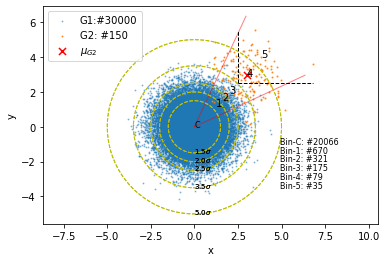

In [52]:
# plotting one example mock bin

A= [0,0]
B= [0,0]
r = 7
A[0] = r*np.cos(np.deg2rad(65))
B[0] = r*np.cos(np.deg2rad(25))
A[1] = r*np.sin(np.deg2rad(65))
B[1] = r*np.sin(np.deg2rad(25))
plt.plot([0, A[0] ], [0, A[1]], ls='-', c='r', alpha=0.5, lw=1)
plt.plot([0, B[0]  ], [0, B[1]], ls='-', c='r', alpha=0.5, lw=1)

(data, G1, G2)=sampler([0,0], [[1,0],[0,1]], [3,3], [[1,0],[0,1]], 30000, 150)
theta = np.zeros([len(data)])
data_norm = erqMedSpec.uniter(data)
for i in tqdm(range(len(data))):
    theta[i] = np.arccos(np.dot(np.array([1,1])/np.sqrt(2), data_norm[i,:]))
plt.plot([2.5, max(data[:,0])], [2.5, 2.5], ls='--', c='black', lw=1)
plt.plot([2.5,2.5], [2.5, max(data[:,1])], ls='--', c='black', lw=1)
plt.scatter(G1[:,0], G1[:,1], s=1, alpha=0.4, label='G1:#30000')
plt.scatter(G2[:,0], G2[:,1], s=1, alpha=0.8, c='C1', label='G2: #150')
plt.scatter(3,3,s=50, c='r', marker='x', label=r'$\mu_{G2}$')


from matplotlib.patches import Circle
from matplotlib.collections import PatchCollection

circles=[]
t= np.linspace(0,2*np.pi, 1000)
for i in tqdm(range(len(rout)-1)):
    x = rout[i]*np.cos(t)
    y = rout[i]*np.sin(t)
    if(i>=3): plt.plot(x,y, c='y',  lw=1, ls='--')
    if(i<3): plt.plot(x,y, c='y',  lw=1, ls='--')
    plt.annotate(r'%.1f$\sigma$'%rout[i], (0,-rout[i]-0.01), fontsize=7, c='k')

plt.ylabel('y')
plt.xlabel('x')
    
from matplotlib.patches import Circle
from matplotlib.collections import PatchCollection

circles=[]
t= np.linspace(0,2*np.pi, 1000)
for i in tqdm(range(len(rout)-1)):
    x = rout[i]*np.cos(t)
    y = rout[i]*np.sin(t)
    if(i>=3): plt.plot(x,y, c='y',  lw=1, ls='--')
    if(i<3): plt.plot(x,y, c='y',  lw=1, ls='--')
    plt.annotate(r'%.1f$\sigma$'%rout[i], (0,-rout[i]-0.01), fontsize=7, c='k')

r2 = data[:,0]**2 + data[:,1]**2
for b in range(len(rin)):  
        if(b>0):
            mask =(r2>=rin[b]**2) & (r2<=rout[b]**2) & (theta<=np.deg2rad(20))
            plt.text(np.median(data[mask,0]), np.median(data[mask,1]), '%d'%b)
            plt.text(4.9, -1-b*.5, 'Bin-%d: #%d'%(b, np.sum(mask)),fontsize=8, color='k')
        else:
            mask =(r2>=rin[b]**2) & (r2<=rout[b]**2)            
            plt.text(4.9, -1, 'Bin-C: #%d'%np.sum(mask), fontsize=8, color='black' )
            plt.text(np.median(data[:,0]), np.median(data[:,1]), 'C', fontsize=8, color='k')
# if(expansion_handle==True): plt.title(str(round(expansion[0],1))+', '+ str(round(expansion[1],1))+ ', ' + str(round(expansion[2],1)))
plt.axis('equal')
plt.legend(loc='upper left')
plt.savefig('Bin-Mock-LOF-2D.png', bbox_inches='tight', format='png', dpi=200)
plt.show()

In [53]:
! cp Bin-Mock-LOF-2D.png ../../../erqPaper/fig/

(100, 6)


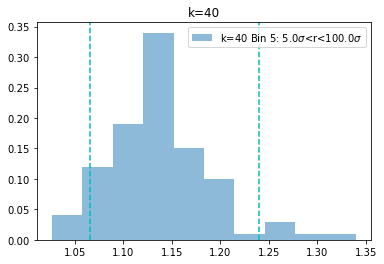

(100, 6)


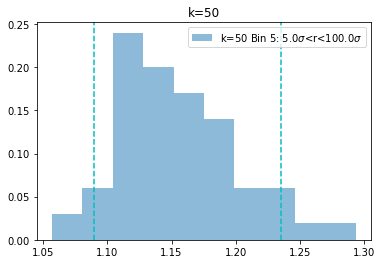

(100, 6)


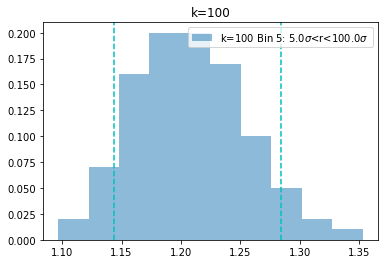

(100, 6)


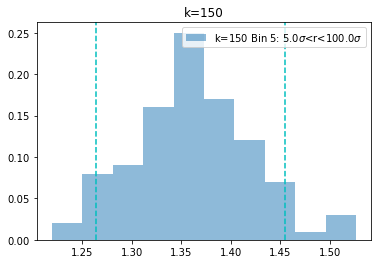

In [48]:

A= [0,0]
B= [0,0]
r=7 # length of the wedge is 4sigma


plt.plot([2.5, max(data[:,0])], [2.5, 2.5], ls='--', c='black', lw=1)
plt.plot([2.5,2.5], [2.5, max(data[:,1])], ls='--', c='black', lw=1)
plt.scatter(G1[:,0], G1[:,1], s=1, alpha=0.4, label='G1:#30000')
plt.scatter(G2[:,0], G2[:,1], s=1, alpha=0.8, c='C1', label='G2: #200')
plt.scatter(3,3,s=50, c='r', marker='x', label=r'$\mu_{G2}$')
from scipy import stats 
for k in [ 40, 50, 100, 150]:
    LOFScoresMedianBins = np.loadtxt('2D-LOFScoresMedianBins-1000Sample-k-%d.dat'%k)
    print(LOFScoresMedianBins.shape)
    P_all =[]
    med_bin=[]
    width= []

    for b in range(nBin):
        N, bins, patch=plt.hist(LOFScoresMedianBins[:,b], bins=10)
        med_bin.append((bins[:-1] + bins[1:])/2)
        width.append(bins[1] - bins[0])
        P_all.append(N/np.sum(N))
        plt.clf()
        plt.cla()

    for b in range(5,nBin):
        plt.bar(med_bin[b], P_all[b], width=width[b],  linewidth=0.5, 
                alpha=.5, label=r'k=%d Bin %d: %.1f$\sigma$<r<%.1f$\sigma$'%(k, b, rin[b],rout[b]))
        u= np.percentile(LOFScoresMedianBins[:,b], 95) 
        l= np.percentile(LOFScoresMedianBins[:,b], 5) 
        plt.axvline(x=l, c='c', ls='--')
        plt.axvline(x=u, c='c', ls='--')
    plt.legend()
    plt.title('k=%d'%k)
    plt.savefig('LOF_MOK_PDF-k-%d.png'%k, dpi=200)
    plt.show()


In [49]:
nBin

6

k=40 b=0 l=3.596e-04 m=1.003e+00 u=2.991e-04
k=40 b=1 l=9.029e-04 m=1.006e+00 u=9.073e-04
k=40 b=2 l=3.172e-03 m=1.022e+00 u=2.316e-03
k=40 b=3 l=8.122e-03 m=1.090e+00 u=6.647e-03
k=40 b=4 l=5.192e-03 m=1.031e+00 u=3.923e-03
k=40 b=5 l=1.491e-02 m=1.134e+00 u=1.738e-02

k=50 b=0 l=3.110e-04 m=1.002e+00 u=3.158e-04
k=50 b=1 l=1.036e-03 m=1.007e+00 u=6.486e-04
k=50 b=2 l=2.659e-03 m=1.025e+00 u=2.196e-03
k=50 b=3 l=6.594e-03 m=1.102e+00 u=1.294e-02
k=50 b=4 l=6.758e-03 m=1.040e+00 u=7.251e-03
k=50 b=5 l=1.944e-02 m=1.147e+00 u=2.363e-02

k=100 b=0 l=3.012e-04 m=1.001e+00 u=4.365e-04
k=100 b=1 l=1.053e-03 m=1.011e+00 u=9.309e-04
k=100 b=2 l=3.528e-03 m=1.046e+00 u=4.291e-03
k=100 b=3 l=1.094e-02 m=1.170e+00 u=1.335e-02
k=100 b=4 l=1.370e-02 m=1.134e+00 u=2.135e-02
k=100 b=5 l=2.484e-02 m=1.208e+00 u=1.938e-02

k=150 b=0 l=2.983e-04 m=1.001e+00 u=2.707e-04
k=150 b=1 l=1.465e-03 m=1.015e+00 u=1.498e-03
k=150 b=2 l=4.233e-03 m=1.062e+00 u=3.535e-03
k=150 b=3 l=1.470e-02 m=1.233e+00 u=1.704e-

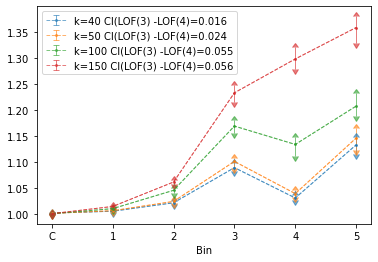

In [56]:
# Plotting 2D Mock LOF error bars 

from scipy import stats 
P_all =[]
med_bin=[]
width= []
c= ['C0', 'C1', 'C2', 'C3', 'C4']
cind=-1
for k in [40, 50,100, 150]:
    DistLOFMedBin = np.loadtxt('2D-LOFScoresMedianBins-1000Sample-k-%d.dat'%k)
    DistDiffMedian = DistLOFMedBin[:,3] - DistLOFMedBin[:,4]
    CI = np.percentile(DistDiffMedian,68) - np.percentile(DistDiffMedian,32)
    l, u, LOFScoreMedian = np.zeros(nBin),  np.zeros(nBin),  np.zeros(nBin)
    for b in range(nBin):
        
        l[b]= np.percentile(DistLOFMedBin[:,b],32)
        u[b]= np.percentile(DistLOFMedBin[:,b],68)
        LOFScoreMedian[b] = np.median(DistLOFMedBin[:,b])       
        u[b]=u[b] - LOFScoreMedian[b]
        l[b]=LOFScoreMedian[b] - l[b]
        print('k=%d b=%d l=%.3e m=%.3e u=%.3e'%(k, b, l[b],LOFScoreMedian[b],u[b]))
    print('')
    cind+=1
    plt.errorbar(['C', '1', '2', '3', '4', '5'], LOFScoreMedian, 
                 yerr=l, uplims=False, lolims=True, marker='o', lw=1, ls='--',
             markersize=2, alpha =0.6, label=r'k=%d CI(LOF(3) -LOF(4)=%.3f'%(k, CI), c=c[cind])
    plt.errorbar(['C', '1', '2', '3', '4', '5'], LOFScoreMedian, 
                 yerr=u, uplims=True, lolims=False, marker='o', lw=1, ls='--',
             markersize=1, alpha =0.6, c=c[cind])
plt.xlabel('Bin')
plt.legend()
plt.savefig('LOF_MOK_2D-errorbar.png', dpi=200, bbox_inches='tight')
plt.show()


In [57]:
! cp LOF_MOK_2D-errorbar.png ../../../erqPaper/fig/